## Imports

In [1]:
# !git clone https://github.com/Holstrup/MetricLearning
# import os
# os.chdir("MetricLearning/MetricLearning")
# !git pull

In [2]:
import sklearn.metrics as sk_metrics
import sklearn.decomposition as sk_decomp
import sklearn.datasets as datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import numpy as np
import Model
import Plots
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import knnClassifier
#from sklearn.utils.extmath import softmax
from scipy.special import softmax
import plot_confusion_matrix as plots
import random
from knnClassifier import calc_mode
from cython.parallel import prange

# We ignore divisions by 0. We will do that in the chi square distance, but we don't care. 
np.seterr(divide='ignore', invalid='ignore')

Using TensorFlow backend.


{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

## Hyperparameters

Underneath you can define the hyperparameters, l, mu and K.
* $l$ is the margin parameter
* $\mu$ is a trade-off parameter between the push and pull in the loss function
* $K$ is the number of target neighbors 
* $D$ is the dimensionality of our data. We choose that arbitrarily
* $L$ is the linear transformation

L is set to be a diagonal matrix of ones to begin with. However, it would be interesting to experiement with other initial L matrices, since the problem is non-convex. We could also try to implement the constrained non-convex version of LMNN.

In [3]:
mu = 0.5
K = 5
D = 10
L = np.eye(D, dtype=float)
alpha = 0.001

## Functions

This block defines two functions that we will use to compute the distances. The first function calculates the distance given two points xi and xj. The second function calculates the distance between some point xi and all the other points X, through the L space. This is very important to note. 

* $chi-square-distance(xi, xj)$ corresponds to (3) in the [Non-linear metric learning paper](http://www.cs.cornell.edu/~kilian/papers/chilmnn.pdf)
* $distance(xi, X)$ is an extension to $chi-square-distance(xi, xj)$, namely finding the chi square distance from one point xi, to all the other points

In [4]:
def chi_square_distance(xi, xj):
    """
    Chi square distance

    :param xi: Embedding       (1, D)
    :param xj: Target Neighbor (1, D)
    :return: Distance
    """
    return 1 / 2 * np.nansum(np.square(xi - xj) / (xi + xj))

def distance(xi, X, L):
    """
    Chi square distance from one point xi, to all other points
    
    :param xi: Embedding       (1, D)
    :param X: Data             (N, D)
    :return: Distances         (1, N)
    
    """
    N, K = np.shape(X)
    Distances = np.zeros(N)
    for i in prange(N):
        Distances[i] = chi_square_distance(L @ xi, L @ X[i, :])
    return Distances

These next functions are calculating the target neighbors and the imposters. Read through the comments, and it should make sense how it is done. One little note: In the target neighbours function, we find the distance through the L space. This is meant as the initial L space. We only find these target neighbours once, and should therefore not update what target neighbors a specific point xi has. 

In [5]:
def find_target_neighbors(X, Y, L):
    """
    Find target neighbours for all points
    
    :param X: Data Matrix      (N, D)
    :param Y: Labels           (1, N)
    :return: TN_lookup_table   (N, K)
    :return: TN_distance_table (N, K)
    """
    
    global TN_lookup_table
    global TN_distance_table
    
    N, _ = np.shape(X)
    TN_lookup_table = np.zeros((N, K))
    TN_distance_table = np.zeros((N, K))

    for i in prange(N):
        xi = X[i,:]
        yi = Y[i]
        
        # Find distance from xi to all other points
        TN_Distances = distance(xi, X, L)
        TN_Indicies = np.argsort(TN_Distances)
        j = k = 0
        
        #Loop to add indicies of target neighbours to lookup table
        while j < K:
            # if yi and target neighbour have the same label AND it is not the same point
            if Y[TN_Indicies[k]] == yi and TN_Indicies[k] != i:
                # Add to lookup table and distance table
                TN_lookup_table[i, j] = TN_Indicies[k]
                TN_distance_table[i, j] = TN_Distances[TN_Indicies[k]]
                j += 1
            k += 1
    TN_lookup_table = TN_lookup_table.astype(int)
    return TN_lookup_table, TN_distance_table

#Check if the impostor is within the margin of the target neighbor + marginal distance l
def check(L, xi, xj, xk):
    return (chi_square_distance(L @ xi, L @ xj) + l >= chi_square_distance(L @ xi, L @ xk)) 

## LMNN Functions

These next functions, are made from looking at this [Chi square Metric Learning for Nearest Neighbor Classification and Its Analysis paper](https://projet.liris.cnrs.fr/imagine/pub/proceedings/ICPR-2012/media/files/1795.pdf). Specifically, if you scroll to the last page you can see the equations that are implemented below. Here are some notes, that helps when you read it: 
* $L_{\alpha, \beta}$ refers to the alpha'th row and the beta'th column in the L matrix. Same goes for all the other places there is subscript. 
* $\psi_{i, j, \alpha}$ in this paper is the same as $t_{i,j}$ in the Yang paper
* In this paper they refer to imposters with the letter l (as opposed to k in the other papers)
* $\xi_{i, j, l}$ I interpret as a check that the point $x_{l}$ is actually an imposter. That should always be the case since, we calculate the imposters this way in the imposters function.

* $gradient-function$ is the main function that deals with computing the gradient
* $gradient-element$ sustains $gradient-function$ and corresponds to (26) and (27) in the above stated [paper](https://projet.liris.cnrs.fr/imagine/pub/proceedings/ICPR-2012/media/files/1795.pdf)
* $outer-loss$ corresponds to (11) - for target neighbors 
* $inner-loss-function$ corresponds to (12) - for impostors

* $tau-function$ ($\Psi$ in the text) corresponds to (25) in the above stated [paper](https://projet.liris.cnrs.fr/imagine/pub/proceedings/ICPR-2012/media/files/1795.pdf) 

In [6]:
#Tau Function
def tau_function(X_Matrix, L_Matrix, i, j, alpha):
    N, D = np.shape(X_Matrix)
    numerator = 0
    denominator = 0
    for k in prange(D):
        numerator +=   L_Matrix[alpha, k] * (X_Matrix[i, k] - X_Matrix[j, k])
        denominator += L_Matrix[alpha, k] * (X_Matrix[i, k] + X_Matrix[j, k])
    return numerator / denominator

In [7]:
def gradient_and_loss_function(X, Y, L_Matrix):
    D, D = np.shape(L_Matrix)
    gradient_matrix = np.zeros((D,D))
    loss = 0
    for alpha in prange(D):
        for beta in prange(D):
            if( (alpha == D-1) and (beta == D-1) ):
                gradient_matrix[alpha, beta], loss = gradient_and_loss_element(X, Y, L_Matrix, alpha, beta, True)
            else:
                gradient_matrix[alpha, beta], _ = gradient_and_loss_element(X, Y, L_Matrix, alpha, beta, True)
    return gradient_matrix, loss
            
def gradient_and_loss_element(X_Matrix, Y, L_Matrix, alpha, beta, return_loss):
    global mu
    N, _ = np.shape(X_Matrix)
    gradient = 0
    outer_sum = 0
    Inner_sum = 0
    loss = 0
    for i in prange(N):
        Pull = 0
        for j in TN_lookup_table[i, :]:
            tauij = tau_function(X_Matrix, L_Matrix, i, j, alpha)
            Lij = 2 * tauij * (X_Matrix[i, beta] - X_Matrix[j, beta]) - (tauij**2) * (X_Matrix[i, beta] + X_Matrix[j, beta])
            outer_sum += Lij
            for k in prange(N):
                # We need to update the distance to our target neighbours and compute the max distance
                if (check(L, X_Matrix[i],  X_Matrix[j],  X_Matrix[k]) and (Y[i] != Y[k])):
                    #print("   ", i, " has imposter ", k)
                    tauik = tau_function(X_Matrix, L_Matrix, i, k, alpha)
                    Lik = 2 * tauik * (X_Matrix[i, beta] - X_Matrix[k, beta]) - (tauik**2) * (X_Matrix[i, beta] + X_Matrix[k, beta])
                    Inner_sum += Lij - Lik
            # Calculate loss
            if(return_loss):
                loss += (1 - mu) * pullLoss(X_Matrix, L_Matrix, i, j) + mu * pushLoss(X_Matrix, Y, L_Matrix, i, j)
            
    gradient = (1 - mu) * outer_sum + mu * Inner_sum
    return gradient, loss

#Loss for pull
def pullLoss(X_Matrix, L_Matrix, i, j):
    return chi_square_distance(L_Matrix @ X_Matrix[i], L_Matrix @ X_Matrix[j])
            
#Loss for push
def pushLoss(X_Matrix, Y, L_Matrix, i, j):
    loss = 0
    N, _ = np.shape(X_Matrix)
    for k in prange(N):
        if (check(L_Matrix, X_Matrix[i],  X_Matrix[j],  X_Matrix[k]) and (Y[i] != Y[k])):
            loss += max(0, l + chi_square_distance(L_Matrix @ X_Matrix[i], L_Matrix @ X_Matrix[j]) - chi_square_distance(L_Matrix @ X_Matrix[i], L_Matrix @ X_Matrix[k]))
    return loss

## Separate implementation of the loss function, gradient for pulling and gradient for pushing

### Implementation of the loss function

In [8]:
def loss_function(X, Y, L_Matrix):
    loss = 0
    D, D = np.shape(L_Matrix)
    for alpha in prange(D):
        for beta in prange(D):
            loss += loss_element(X, Y, L_Matrix, alpha, beta)
    return loss

def loss_function2(X, Y, L_Matrix):
    loss = 0
    N, D = np.shape(X)
    for i in prange(N):
        for j in TN_lookup_table[i]:
            loss += (1-mu)*chi_square_distance(L_Matrix @ X[i], L_Matrix @ X[j])
            for k in prange(N):
                if (check(L_Matrix, X[i],  X[j],  X[k]) and (Y[i] != Y[k])):
                    loss += mu*(l + chi_square_distance(L_Matrix @ X[i], L_Matrix @ X[j]) - chi_square_distance(L_Matrix @ X[i], L_Matrix @ X[k]))
    return loss

def loss_element(X, Y, L_Matrix, alpha, beta):
    loss = 0
    global mu
    N, _ = np.shape(X)
    
    for i in prange(N):
        Pull = 0
        for j in TN_lookup_table[i, :]:
            # Calculate loss
            loss += (1 - mu) * pull_loss(X, L_Matrix, i, j) + mu * push_loss(X, Y, L_Matrix, i, j)
    return loss

#Loss for pull
def pull_loss(X_Matrix, L_Matrix, i, j):
    return chi_square_distance(L_Matrix @ X_Matrix[i], L_Matrix @ X_Matrix[j])

#Loss for push
def push_loss(X_Matrix, Y, L_Matrix, i, j):
    loss = 0
    N, _ = np.shape(X_Matrix)
    for k in prange(N):
        if (check(L_Matrix, X_Matrix[i],  X_Matrix[j],  X_Matrix[k]) and (Y[i] != Y[k])):
            loss += max(0, l + chi_square_distance(L_Matrix @ X_Matrix[i], L_Matrix @ X_Matrix[j]) - chi_square_distance(L_Matrix @ X_Matrix[i], L_Matrix @ X_Matrix[k]))
    return loss

### Implementation of the gradient for pulling and pushing

* $Pull(XMatrix, LMatrix)$ corresponds to (26)
* $Push(XMatrix, LMatrix, Y)$ corresponds to (27)

In [9]:
### PULL FUNCTIONS
def Pull(X_Matrix, L_Matrix):
    D, D = np.shape(L_Matrix)
    gradient_matrix = np.zeros((D,D))
    for alpha in prange(D):
        for beta in prange(D):
            gradient_matrix[alpha, beta] = Pull_matrix_element(X_Matrix, L_Matrix, alpha, beta)
    return gradient_matrix

def Pull_matrix_element(X_Matrix, L_Matrix, alpha, beta):
    N, D = np.shape(X_Matrix)
    gradient = 0
    for i in prange(N):
        for j in TN_lookup_table[i, :]:
            tau = tau_function(X_Matrix, L_Matrix, i, j, alpha)
            gradient += 2 * tau * (X_Matrix[i, beta] - X_Matrix[j, beta]) - (tau**2) * (X_Matrix[i, beta] + X_Matrix[j, beta])
    return gradient

In [10]:
### PUSH FUNCTIONS
def Push(X_Matrix, L_Matrix, Y):
    D, D = np.shape(L_Matrix)
    gradient_matrix = np.zeros((D,D))
    for alpha in prange(D):
        for beta in prange(D):
            gradient_matrix[alpha, beta] = Push_matrix_element(X_Matrix, L_Matrix, Y, alpha, beta)
    return gradient_matrix

def Push_matrix_element(X_Matrix, L_Matrix, Y, alpha, beta):
    N, D = np.shape(X_Matrix)
    gradient = 0
    for i in prange(N):
        for j in TN_lookup_table[i, :]:
            for k in prange(N):
                if (check(L, X_Matrix[i],  X_Matrix[j],  X_Matrix[k]) and (Y[i] != Y[k])):
                    tauij = tau_function(X_Matrix, L_Matrix, i, j, alpha)
                    tauik = tau_function(X_Matrix, L_Matrix, i, k, alpha)
                    Lij = 2 * tauij * (X_Matrix[i, beta] - X_Matrix[j, beta])          - (tauij**2) * (X_Matrix[i, beta] + X_Matrix[j, beta])
                    Lik = 2 * tauik * (X_Matrix[i, beta] - X_Matrix[k, beta]) - (tauik**2) * (X_Matrix[i, beta] + X_Matrix[k, beta])
                    gradient += Lij - Lik
    return gradient

The update for the gradient is done based on the predefined learning rate.
The gradient should not be negative and its values should sum up to 1. Thus, we have made use of the softmax function for updating the gradient.

In [11]:
def update_step(G):
    """
    Update L
    
    :param G: Computed gradient for a given iteration
    """
    global L
    new_L = L - alpha * G
    L = softmax(new_L, axis = 0)

## Artificial Data

In [12]:
pts=np.random.dirichlet([.5,.5,.5], size = 100)

C1 = pts[:,0] > 0.4
C2 = pts[:,1] > 0.4
C3 = np.logical_and(np.logical_not(C1), np.logical_not(C2))

## To create some noise we make 12 of the C1 observations the other classes.
n_remove = 10
c1remove = random.sample(prange(len(C1)), n_remove)
C1[c1remove] = False
C2[c1remove[0:int(n_remove*0.5 - 1)]] = True
C3[c1remove[int(n_remove*0.5):int(n_remove - 1)]] = True

c2remove = random.sample(prange(len(C2)), n_remove)
C2[c2remove] = False
C1[c2remove[0:int(n_remove*0.5 - 1)]] = True
C3[c2remove[int(n_remove*0.5):int(n_remove - 1)]] = True

c3remove = random.sample(prange(len(C2)), n_remove)
C3[c3remove] = False
C1[c3remove[0:int(n_remove*0.5 - 1)]] = True
C2[c3remove[int(n_remove*0.5):int(n_remove - 1)]] = True

In [13]:
# Based on post from Thomas Boggs (http://blog.bogatron.net/blog/2014/02/02/visualizing-dirichlet-distributions/)
_corners = np.array([[0, 0], [1, 0], [0.5, 0.75**0.5]])
_triangle = tri.Triangulation(_corners[:, 0], _corners[:, 1])

def plot_points(X, labels, centre, ind):
    '''Plots a set of points in the simplex.

    Arguments:

        `X` (ndarray): A 2xN array (if in Cartesian coords) or 3xN array
                       (if in barycentric coords) of points to plot.
    '''
    if len(X) != len(labels):
        print("Dimensions don't match...")
        return 0
    
    C1 = (labels == 0)
    C2 = (labels == 1)
    C3 = (labels == 2)
    
    MS = 0
    if centre:
        MS = 2
    else:
        MS = 8
    
    X = X.dot(_corners)  #This is what converts the original points onto the simplex (it projects on it, through dot product)
    plt.plot(X[C1, 0], X[C1, 1], 'k.', ms=MS, c = "red")
    plt.plot(X[C2, 0], X[C2, 1], 'k.', ms=MS, c = "blue")
    plt.plot(X[C3, 0], X[C3, 1], 'k.', ms=MS, c = "green")

    if(ind >= 0):
        plt.plot(X[ind, 0], X[ind, 1], '*', ms=MS, c = "black")
    plt.axis('equal')
    if centre:
        plt.xlim(0.3, 0.7)
        plt.ylim(0.33, 0.34)
    else:
        plt.xlim(0, 1)
        plt.ylim(0, 0.75**0.5)
    
    plt.axis('off')
    plt.triplot(_triangle, linewidth=1)
    plt.show()

In [14]:
label = np.zeros(len(pts))
label[C1] = 0
label[C2] = 1
label[C3] = 2
X_train, X_test, y_train, y_test = train_test_split(pts, label, test_size=0.2, random_state=0)

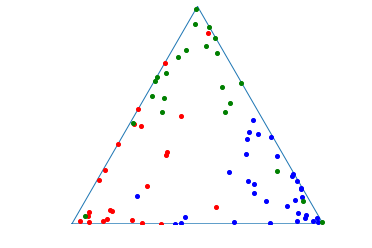

In [15]:
#It's very important to set the margin very low as the data points are quite densly packed
mu = 0.5
K = 3
alpha = 0.0001
l = 0.15
_, D = np.shape(X_train)
L = np.eye(D)

TN_lookup_table, TN_distance_table = find_target_neighbors(X_train, y_train, L)
C1train = (y_train == 0)
C2train = (y_train == 1)
C3train = (y_train == 2)

plot_points(X_train, y_train, False, -1)

In [16]:
ITERATIONS = 3
lossOld = 0
lRange = np.arange(0.05, 0.3, 0.05)
alphaRange = np.arange(0.05, 0.3, 0.05)
muRange = np.arange(0.1, 0.6, 0.1)

## Initialize the lists for ploting and finding the best combination
lossList = []
accuracy = []
lList = []
alphaList = []
muList = []

        
for l in lRange:

    ## Initialise L matrix as suggested in the paper
    L = 10*np.eye(D, dtype=float) + 0.01*D
    L = softmax(L, axis = 0)

    ## Update the gradient and check the loss
    for i in prange(ITERATIONS):
        print("  Iteration: ", i+1)

        ## Calculate the gradient and the loss
        Gt, lossNew = gradient_and_loss_function(X_train, y_train, L)

        ## Loss scores
        lossList.append(lossNew)
        print(lossList)

        ## Plot the data step-wise
        ## plot_points( (L @ X_train.T).T, y_train, False, -1)

        ## Checks and behavior updates
        if(abs(lossNew - lossOld) < 1e-8):
            print("Converged...")
            break

        lossOld = lossNew

        ## Accuracy scores
        prediction = []
        for i in prange(len(X_test)):
            prediction.append(random.choice(calc_mode(knnClassifier.knn(X_test[i], X_train, y_train, L, 5))))
        accuracy.append(accuracy_score(y_test.astype(str), prediction))
        print("   Accuracy of iteration = ", accuracy[-1])

        ## Update the transformation matrix using the gradient.
        update_step(Gt)

  Iteration:  1
[47.388095716246625]
   Accuracy of iteration =  0.95
  Iteration:  2
[47.388095716246625, 70.43786813163956]
   Accuracy of iteration =  0.95
  Iteration:  3
[47.388095716246625, 70.43786813163956, 254.8493068034073]
   Accuracy of iteration =  0.95
  Iteration:  1
[47.388095716246625, 70.43786813163956, 254.8493068034073, 79.81512229881804]
   Accuracy of iteration =  0.95
  Iteration:  2
[47.388095716246625, 70.43786813163956, 254.8493068034073, 79.81512229881804, 257.7553643201854]
   Accuracy of iteration =  0.95
  Iteration:  3
[47.388095716246625, 70.43786813163956, 254.8493068034073, 79.81512229881804, 257.7553643201854, 533.1837007201052]
   Accuracy of iteration =  0.95
  Iteration:  1
[47.388095716246625, 70.43786813163956, 254.8493068034073, 79.81512229881804, 257.7553643201854, 533.1837007201052, 123.93054753965988]
   Accuracy of iteration =  0.95
  Iteration:  2
[47.388095716246625, 70.43786813163956, 254.8493068034073, 79.81512229881804, 257.755364320185

In [138]:
print("List of alphas: ", len(alphaList))
print("List of margins: ", len(lList))
print("List of mu: ", len(muList))
print("Loss number: ", len(lossList))

List of alphas:  5
List of margins:  25
List of mu:  125
Loss number:  375


## Plots

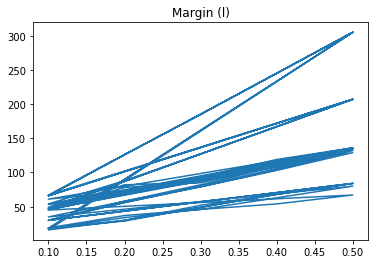

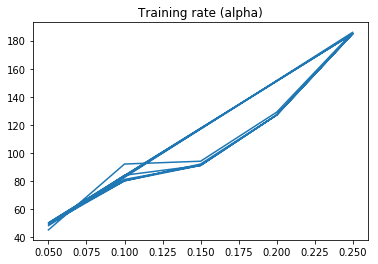

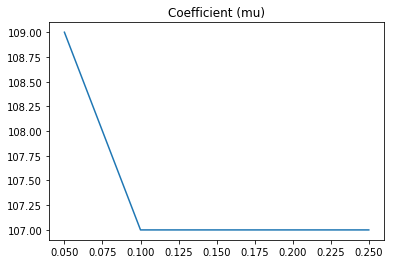

In [141]:
acc = accuracy[::ITERATIONS]
plt.plot(lList, acc)
plt.show()

## The right index for each componet should be determined

In [152]:
maxAccIndex = accuracy.index(max(accuracy))
minLIndex = int(np.ceil(minMuIndex/ITERATIONS))
print("Max accuracy: ", max(accuracy))

Minimum loss:  12.395884551910171


## Consider only the most optimal parameters

In [151]:
titles = ["Margin (l)", "Training rate (alpha)", "Coefficient (mu)"]
lists = [lList, alphaList, muList]
indexes = [minLIndex, minAlphaIndex, minMuIndex]

for i in prange(len(lists)):
    print("Best values for {}: ".format(titles[i]), lists[i][indexes[i]])

Best values for Margin (l):  0.1
Best values for Training rate (alpha):  0.2
Best values for Coefficient (mu):  0.2


## Visualizations

In [165]:
prediction = []
for i in prange(len(X_test)):
    prediction.append(random.choice(calc_mode(knnClassifier.knn(X_test[i], X_train, y_train, L, 10))))
accuracy_score(y_test.astype(str), prediction)

0.8

In [179]:
L[0] = [0.3351447,  0.33249944, 0.33235902]
L[1] = [0.33249707, 0.33484983, 0.33264931]
L[2] = [0.33235823, 0.33265073, 0.33499167]

In [181]:
L[0] = np.array([0.58114561, 0.12985278, 0.32734025])
L[1] = np.array([0.06352982, 0.71862922, 0.13309158])
L[2] = np.array([0.35532456, 0.15151801, 0.53956817])

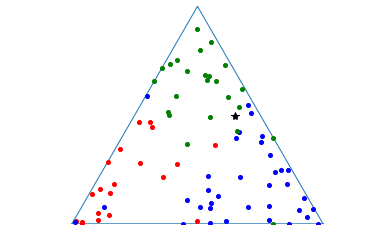

In [156]:
plot_points( (L @ X_train.T).T, y_train, False, 0)

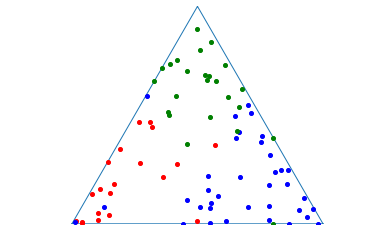

In [157]:
plot_points(X_train, y_train, False, -1)

## Parameter initialization and lookup table

In [167]:
#It's very important to set the margin very low as the data points are quite densly packed
mu = 0.2
K = 1
alpha = 0.02
_, D = np.shape(X_train)
L = np.eye(D, dtype=float)

In [168]:
TN_lookup_table, TN_distance_table = find_target_neighbors(X_train, y_train, L)
l = 0.1

### Histograms using the initial linear transformation matrix L

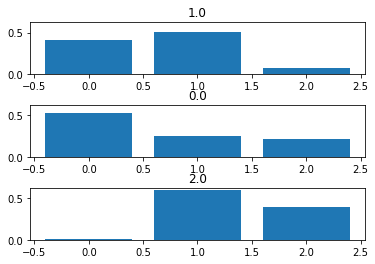

In [162]:
new_X = (L @ X_train.T).T

plot_items = new_X[10:25:5,:]
plot_labels = y_train[10:25:5]
Plots.plot_some_data(plot_items, plot_labels)

## Run

0
[[0.56669732 0.18413475 0.18032518]
 [0.22823836 0.58769675 0.20085815]
 [0.20506432 0.2281685  0.61881666]]
9.79293994275151


1
[[0.92966253 0.02459221 0.03390534]
 [0.03546211 0.94706389 0.02571504]
 [0.03487537 0.02834391 0.94037961]]
37.79871842468788


2
[[0.57488779 0.19492422 0.19173185]
 [0.22959189 0.58341425 0.20725964]
 [0.19552032 0.22166154 0.60100851]]
10.270294044349525


3
[[0.93924147 0.02286333 0.03289051]
 [0.03134839 0.95072702 0.02543929]
 [0.02941014 0.02640965 0.9416702 ]]
38.892919546237735


4
[[0.57673285 0.19374177 0.19245642]
 [0.22851415 0.58456305 0.20771348]
 [0.194753   0.22169518 0.5998301 ]]
10.226729506835513


5
[[0.93647321 0.02397263 0.03349266]
 [0.0331087  0.94921155 0.0255035 ]
 [0.03041808 0.02681581 0.94100384]]
38.74699392444485


6
[[0.57591948 0.19459169 0.19246105]
 [0.22904273 0.58396905 0.20730193]
 [0.19503779 0.22143926 0.60023703]]
10.240991706284161


7
[[0.93797245 0.02341685 0.03334748]
 [0.03213324 0.94989363 0.02557516]
 [0.02

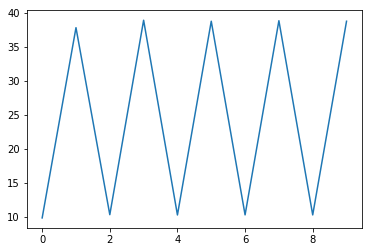

In [169]:
ITERATIONS = 10
lossList = []

for i in prange(ITERATIONS):
    print(i)
    #Gt = (1 - mu) * Pull(X_train, L) + mu * Push(X_train, L, y_train)
    #loss = loss_function(X_train, y_train, L)
    Gt, loss = gradient_and_loss_function(X_train, y_train, L)
    lossList.append(loss)
    update_step(Gt)
    print(L)
    print(loss)
    print("\n")
    

plt.plot(lossList, '-')
plt.show()

As expected, the loss follows an exponentially decreasing function. Having as component the loss from pushing the impostors and pulling the target neighbors, this means that the target neighbors are pulled closer and the impostors pushed away.

### Plot of the linear trasformation matrix L

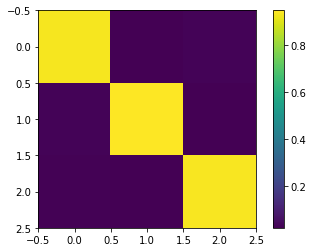

In [170]:
Plots.plot_kernel(L)

### Histograms using the updated linear transformation matrix L

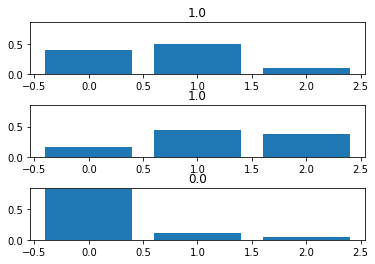

array([[0.40225662, 0.50119244, 0.09655094],
       [0.16330309, 0.44955529, 0.38714162],
       [0.83413866, 0.11864092, 0.04722041]])

In [171]:
#new_X = X_train
new_X = (L @ X_train.T).T
plot_items = new_X[10:20:4,:]
plot_labels = y_train[10:20:4]
Plots.plot_some_data(plot_items, plot_labels)
new_X[10:20:4,:]

## Confusion matrix stating the accuracy

Further, in order to check the increase in accuracy, we have implemented a knnClassifier

Confusion matrix, without normalization
[[2 1 0]
 [0 7 1]
 [0 3 6]]


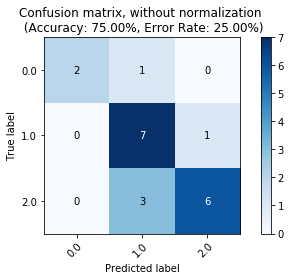

In [174]:
import plot_confusion_matrix
prediction = []

for i in prange(len(X_test)):
    prediction.append(random.choice(calc_mode(knnClassifier.knn(X_test[i], X_train, y_train, L, 10))))
confusion_matrix = plot_confusion_matrix.plot_confusion_matrix(y_test.astype(str), prediction, normalize=False)

Confusion matrix, without normalization
[[2 1 0]
 [0 7 1]
 [0 3 6]]


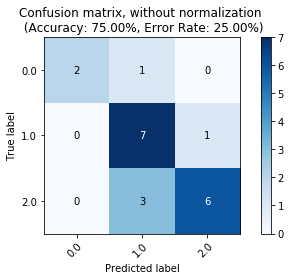

In [176]:
prediction = []

for i in prange(len(X_test)):
    prediction.append(random.choice(calc_mode(knnClassifier.knn(X_test[i], X_train, y_train, np.eye(D), 10))))
confusion_matrix = plot_confusion_matrix.plot_confusion_matrix(y_test.astype(str), prediction, normalize=False)